In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%%capture
!pip install tensorflow-addons

In [6]:
# get the dataset and gan classes for use

import sys
sys.path.append('/content/drive/MyDrive/Chapman/510/Project/Classes')

In [7]:
import csv
import glob
import math
import zipfile
import numpy as np
import pandas as pd
import seaborn as sb
import gan
import dataset as ds
import tensorflow as tf 
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.integrate import simps, cumtrapz
from scipy.fft import fft, ifft, fftfreq
from numpy.lib.function_base import average

In [8]:
# get all sims into the runtime before we start having to do everything else
# this should make the program run much faster than having to load each file just-in-time

zippath = 'drive/MyDrive/Chapman/510/Project/sims.zip'

print('unzipping files in runtime environment. this will take ~5 minutes.')

sims = zipfile.ZipFile(zippath, 'r')
sims.extractall(path='/')
sims.close()

print('...done.')

unzipping files in runtime environment. this will take ~5 minutes.
...done.


In [9]:
# define key variables/arguments

loadweights = True
usebias     = True
amsgrad     = False
labs        = 2
glr         = 1e-2
dlr         = 1e-2
b1          = 0.3
b2          = 0.8
nrns        = 512
r1g         = 1e0
epsln       = 1e-5
res         = 1024
bsize       = 32
ksize       = 9

matchtab    = []
labels      = ['freq', 'amp']
metadata    = metadata = 'drive/MyDrive/Chapman/510/Project/METADATA.csv'
mdat        = pd.read_csv(metadata, sep='\t')
pathway     = '/sims'
simpath2    = pathway + '/1.csv'
outpath     = f'drive/MyDrive/Chapman/510/Project/Outs/{nrns}n_{glr}_{dlr}_c'
weights     = outpath + '/weights'
s1          = str(outpath + '/series')

In [10]:
# functions to calculate the MSE of the wave and the MSE of the wave's derivative

def calc_MSE(x1, x2):
    mse = 0
    for i in range(len(x1)):
        mse += (x1[i]-x2[i])**2/(len(x1))
    return mse

In [11]:
# load the gan for a specific epoch 

%%capture
epoch   = '200000'

# load the dataset
dataset = ds.Dataset(batch_size=bsize, pathway=pathway, mdpath=metadata, outpath=outpath, endres=res)

# call the GAN class
msgg = gan.MSG_GAN_ts(neurs=nrns, endres=res, g_lr=glr, d_lr=dlr, r1_gamma=r1g, epsilon=epsln, 
                        outpath=outpath, epochs=1000000, nchannels=1, ksize=ksize, usebias=usebias, nlabels=labs,
                        beta1=b1, beta2=b2, amsgrad=amsgrad, batch_size=bsize)

msgg.D.load_weights(weights + '/discriminator' + epoch + '.h5')
msgg.G.load_weights(weights + '/generator' + epoch + '.h5')

In [ ]:
'''
Evaluating the results

The following cell plots a pseudo-random collection of outputs from the GAN, plotted against the original training
files with matching amplitudes and frequencies (the intended results). Plots for each output are shown in both the 
time domain and frequency domain. 

The cell also contains calculations for the MSE between the GAN output and the intended waveform from the 
training set. At the bottom of the time cell is a printed statement that identifies the best MSE found, and at
which number it was found. It is worth noting that the derivative of each waveform was taken and the MSE caclulated for 
the derivatives as well, so we get a calculation for the average accuracy of both the position and slope of the points
in the time series. 

The frequency domain plots in particular give a great visual representation of how the GAN is handling the data: while 
plots 21 and 32 show the accurate frequency output, for example, plots 22-31 do not get the frequency correct. Instead,
these ranges seem to treat the intermediate frequencies as weighted sums of the two frequencies found in plots 21 and 
32. This indicates that the network is treating the frequencies as categorical labels and is binning frequencies into 
"nearby groups".



Discussion/next steps

This network clearly struggled to interpret the input variables for amplitude and frequency as numerical labels and 
instead binned them into categorical groups, using superpositions of each group to attempt to explain the intermediate
frequencies and amplitudes.

There have been recent papers that propose a technique of adding small amounts of noise to the input numerical labels
during training so that the GAN sees the exact same image more than once, but with slightly different numerical labels
that are very similar to each other. This in theory helps the network understand that numerical labels exist in a 
continuous numerical parameter space and helps the system identify numerical labels as existing with "nearby neighbors"
(it should recognize that 0.1 is a number and that it is very close to 0.11, for example). While adding small amounts
of noise to the labels creates an upper limit to the accuracy of the GAN outputs, it in theory helps keep the network
from binning labels as categorical, thereby giving better overall results for continuous numerical parameter spaces.
This would be the first technique I'd like to try next.

It is also possible that the way this particular network handles the downsizing of the original data is reslulting in
creating "beat frequencies" (https://en.wikipedia.org/wiki/Beat_%28acoustics%29), which would significantly increase 
the difficulty of the GAN's job. Handling the image downsizing steps in a different manner in potentially both the GAN
(specifically in the discriminator) and the dataset processing when feeding images to the GAN could help alleviate this
problem. In all, this is still a relatively new and difficult area of exploration in GAN architectures.
'''

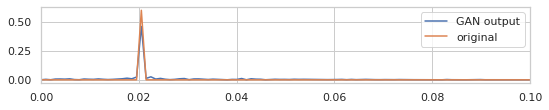

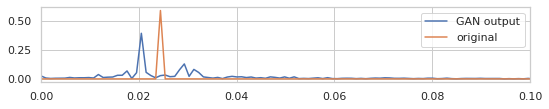

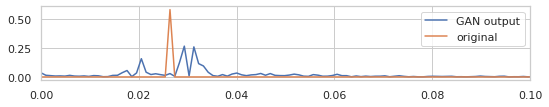

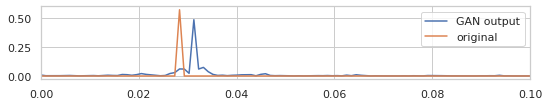

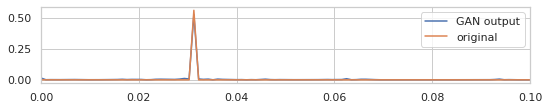

min amp MSE: 0.001 at 4
avg amp MSE: 0.169


In [15]:
# compare results visually and numerically for a pseudo-random collection of waves from the dataset
# compared against the gan's outputs of waves with the same values for amplitude and frequency

mdat2 = mdat.sort_values(by=['sim'])

sb.set_theme(style='whitegrid')

n       = 0
mses    = []
dmses   = []
points  = 1024
start   = 0
end     = points - start

# for i in range(0, 100):
for i in [21, 25, 27, 29, 32]:
    g       = i*100
    locstr  = mdat.loc[g, 'sim']
    lbls    = mdat.loc[g, labels].to_numpy(dtype=np.float32)
    lblstr = str('amp_' + str(lbls[1]) + '_freq_' + str(lbls[0]))
    s1 = str(outpath + '/series')
    s2 = str(s1 + '/' + str(epoch))
    s3 = str(s2 + '/' + str(lblstr))

    objs = glob.glob(s3 + '/*', recursive=True)

    if len(objs) == 0:
        msgg.makewaves(dataset, epoch, lbls)
        objs = glob.glob(s3 + '/*', recursive=True)
        
    x1  = pd.read_csv(objs[0], header=None, delim_whitespace=True)[0]
    x1  = x1.to_numpy(dtype=np.float32)
    x1d = np.gradient(x1)
    x1f = fft(x1)
    xff = fftfreq(points, 1)[0:points//2]

    try:
        x2  = pd.read_csv(locstr, sep='\t').to_numpy(dtype=np.float32)
    except:
        x2  = pd.read_csv('/'+locstr, sep='\t').to_numpy(dtype=np.float32)
    x2d = np.gradient(x2[:,1])
    x2f  = fft(x2[:,1])

    a = calc_MSE(x1, x2[:,1])
    ad = calc_MSE(x1d, x2d)

    mses.append(float('%.3g' % a))
    dmses.append(float('%.3g' % ad))

    # fig, (sp1, sp2) = plt.subplots(2, 1, figsize=(12,6))
    fig, sp2 = plt.subplots(1, 1, figsize=(8,2))

    # print(n)
    n += 1

    # fig.suptitle('target: amp=' + str(lbls[1]) + ', freq=' + str(lbls[0]), y=1)

    # sp1.plot(x2[start:end,0], x1[start:end], label='GAN output')
    # sp1.plot(x2[start:end,0], x2[start:end,1], label='original')
    # sp1.axis(ymin=-1, ymax=1)
    # sp1.legend(loc='best')
    # sp1.set_xlabel('Time')
    # sp1.set_ylabel('Amplitude')

    sp2.plot(xff, 2.0/points*np.abs(x1f[0:points//2]), label='GAN output')
    sp2.plot(xff, 2.0/points*np.abs(x2f[0:points//2]), label='original')
    sp2.axis(xmin=0, xmax=0.1)
    sp2.legend(loc='best')
    # sp2.set_xlabel('Frequency')
    # sp2.set_ylabel('Amplitude')
 
    plt.tight_layout(pad=2.0)
    plt.show()

    aavg  = str('%.3f' % (sum(mses)/len(mses)))
    adavg = str('%.3f' % (sum(dmses)/len(dmses)))
    amin  = min(mses)

    # print('amp MSE:', a, 'amp derivative MSE:', ad, '\n\n')
    # print('')

print('min amp MSE:', str('%.3f' % amin), 'at', str(mses.index(amin)))
print('avg amp MSE: ' + str(aavg))